In [2]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import adapt.ml.lda as dlda
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import adapt.ml.dl_subclass as dl
import copy as cp
import tensorflow as tf
import pickle
from datetime import datetime
import time
from IPython import display
import gc as gc

set_gpu()

Num GPUs Available:  1


In [ ]:
type(mu_class)

In [21]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
if 'skip' in subs:
    subs = np.delete(subs,subs.index('skip'))
bat = 32
load_mod = True
mod_tot = ['blda','lda','crlda','alda','bcnn','cnn', 'crcnn2','acnn05','acnn30','acewc30','acewc15', 'adcnn30', 'vcnn', 'bvcnn', 'avcnn', 'avcnn15', 'acnnl03','crvcnn','acewclm','crcnn','acewc00','xtra2']
ft = 'tdar'
iter = 10
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_mod = 0

for it in range(1):#iter):
    # first iteration, includes LDA; others exclude LDA
    if it == 0:
        mod_all = ['blda','lda','alda','cnn','acnn05','avcnn']#,'crcnn']
        mod_all = ['lda','alda','acnn05','avcnn']
        mod_all = ['acnn05','avcnn']
    else:
        mod_all = ['bcnn','cnn','acnn05','avcnn']

    for sub in range(4,5):
        print(subs[sub])
        sub_path = path + subs[sub] + '/DATA/MAT/'
        all_files = os.listdir(sub_path)
        if 'skip' in all_files:
            all_files = np.delete(all_files,all_files.index('skip'))

        # load or initialize cnn weights
        if load_mod:
            with open(subs[sub] + '_' + str(it) + '_r_accs_y.p','rb') as f:
                all_acc, all_recal, all_val, all_prev, all_train, all_times, all_dof,_, _, c_weights, v_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
        else:
            c_weights = None
            v_weights = None
            v_wc = None
            cl_wc = None
            scaler_0 = None
            all_recal = np.zeros((len(all_files),len(mod_tot)))
            all_acc = np.zeros((len(all_files),len(mod_tot)))
            all_val = np.zeros((len(all_files),len(mod_tot)))
            all_prev = np.zeros((len(all_files),len(mod_tot)))
            all_train = np.zeros((len(all_files),len(mod_tot)))
            all_times = np.zeros((len(all_files),len(mod_tot)))
            rows, cols = (len(all_files), len(mod_tot))
            all_dof = [[0]*cols]*rows

        mod_i = 0
        for mod in mod_all:
            acc = np.zeros((len(all_files),2))
            acc_val = np.zeros((len(all_files),2))
            acc_prev = np.zeros((len(all_files),2))
            acc_train = np.zeros((len(all_files),2))
            mod_recal = np.zeros((len(all_files),))

            if 'lda' in mod:
                acc_i = 0
            else:
                acc_i = 1

            cnn = None
            ewc = None
            clda = None

            ep = 30
            recal = 0
            skip_recal = 0
            skip = False

            # Loop through files
            for i in range(0,len(all_files)-1):
                # Check if need to recalibrate
                if i > 0:
                    if acc[i,acc_i] < 75:
                        skip = False
                        recal += 1
                        print('recal: ' + str(recal) + ' ' + all_files[i])
                        acc[i,acc_i] *= -1
                        mod_recal[i] = 1
                    else:
                        skip = True
                    
                    if 'b' in mod:
                        skip = True
                        
                if not skip:
                    # load training file
                    train_file = all_files[i]
                    train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')

                    # if first train, use two train files
                    if i == 0:
                        # load training file
                        train_file2 = all_files[i+1]
                        train_data2, train_params2 = prd.load_caps_train(sub_path + train_file2 + '/traindata.mat')
                        train_data = np.vstack((train_data,train_data2))
                        train_params = np.vstack((train_params,train_params2))
                        train_data, train_params, th = prd.threshold(train_data, train_params)
                        val_data, val_params = train_data, train_params
                    else:
                        train_data, train_params, _ = prd.threshold(train_data, train_params,th)
                    
                        tr_i = np.zeros((train_params.shape[0],))
                        te_i = np.zeros((train_params.shape[0],))
                        for cls in np.unique(train_params[:,-1]):
                            dof = np.array(np.where(train_params[:,-1] == cls))
                            tr_i[dof[0,:dof.shape[1]//2]] = 1
                            te_i[dof[0,dof.shape[1]//2:]] = 1

                        train_temp = train_data[tr_i.astype(bool),...]
                        params_temp = train_params[tr_i.astype(bool),...]
                        val_data = train_data[te_i.astype(bool),...]
                        val_params = train_params[te_i.astype(bool),...]
                        
                        train_data, train_params = train_temp, params_temp
                        del train_temp, params_temp, tr_i, te_i
                        
                    # if combining, save current training data
                    # if 'cr' in mod:
                    #     # combine old and new training data
                    #     if i > 1:
                    #         train_data = np.vstack((train_data_0,train_data))
                    #         train_params = np.vstack((train_params_0,train_params))

                    #     train_data_0 = cp.deepcopy(train_data)
                    #     train_params_0 = cp.deepcopy(train_params)

                    # if (i == 1 and mod[0] == 'a') or (i == 1 and mod[:2] == 'cr') or (mod[0] != 'a' and mod[:2] != 'cr'):
                        
                    if i > 0:
                        # get previous dofs
                        prev_ndof = [n_dof, key, train_dof]
                        if mod[0] == 'a':
                            print('prev: ' + str(train_dof))
                            # get current dofs and create key
                            train_dof = np.unique(train_params[:,-1])
                            print('cur: ' + str(train_dof))
                            key = np.zeros((len(train_dof),))
                            # check if current dofs are all in old dof list
                            dof_ovlp = np.isin(train_dof,prev_ndof[2],assume_unique=True)
                            temp_dof = cp.deepcopy(train_dof)
                            # loop through dofs that are in previous dofs, set the keys
                            for dof in train_dof[dof_ovlp]:
                                key[train_dof==dof] = prev_ndof[1][prev_ndof[2]==dof]
                                temp_dof[train_dof==dof] = prev_ndof[2][prev_ndof[2]==dof]

                            # check if previous dofs has classes not in this set
                            dof_xtra = ~np.isin(prev_ndof[2],temp_dof,assume_unique=True)
                            temp_dof = np.hstack((temp_dof,prev_ndof[2][dof_xtra]))
                            key = np.hstack((key,prev_ndof[1][dof_xtra]))

                            # loop through dofs that are not in previous dofs (ie new classes), add keys
                            key_i = 1
                            xtra = False
                            for dof in train_dof[~dof_ovlp]:
                                # if 'lda' in mod:
                                # xtra = True
                                # key[temp_dof==dof] = np.max(key) + 1
                                    # key_i += 1
                                # else:
                                    # remove extras
                                print('removing train ' + str(dof))
                                ind = train_params[:,-1] == dof
                                train_params = train_params[~ind,...]
                                train_data = train_data[~ind,...]
                                ind = val_params[:,-1] == dof
                                val_params = val_params[~ind,...]
                                val_data = val_data[~ind,...]
                                key = np.delete(key,temp_dof==dof)
                                temp_dof = np.delete(temp_dof,temp_dof==dof)

                            train_dof = cp.deepcopy(temp_dof)
                        else:
                            # get current dofs and create key
                            train_dof = np.unique(train_params[:,-1])
                            key = np.arange(len(train_dof))
                    else:
                        # get current dofs and create key
                        train_dof = np.unique(train_params[:,-1])
                        key = np.arange(len(train_dof))

                    n_dof = len(train_dof)
                    all_dof[i][mod_tot.index(mod)] = train_dof

                    train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key,False)
                    val_data, val_params = lp.check_labels(val_data,val_params,train_dof,key,False)

                    print('train dof: ' + str(train_dof) + ', key: ' + str(key))

                    if (mod[0] == 'a' and i > 0) or ('cr' in mod and i > 0) or (mod == 'vcnn' and i > 0):
                        _, x_clean_cnn, y_clean, _, x_train_cnn, y_train, x_train_lda, y_train_lda, _, _, _, _ = prd.prep_train_caps(train_data, train_params, emg_scale=emg_scale, scaler=scaler, num_classes=n_dof, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False)
                    else:
                        _, x_clean_cnn, y_clean, _, x_train_cnn, y_train, x_train_lda, y_train_lda, emg_scale, scaler, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False,num_classes=n_dof)
                        if ((i == 0) and (c_weights is not None)) or ((i == 0) and (v_weights is not None)):
                            scaler = cp.deepcopy(scaler_0)

                    _, _, _, _, x_val_cnn, y_val, x_val_lda, y_val_lda, _, _, _, _ = prd.prep_train_caps(val_data, val_params, emg_scale=emg_scale,scaler=scaler, prop_b=False, batch_size=bat, ft=ft, num_classes=n_dof, noise=False, split=False)

                    if 'cr' in mod:
                        # combine old and new training data
                        if i > 0:
                            x_clean_cnn = np.vstack((clean_data_0,x_clean_cnn))
                            y_clean = np.vstack((clean_params_0,y_clean))
                            x_train_cnn = np.vstack((x_clean_cnn,x_train_cnn))
                            y_train = np.vstack((y_clean,y_train))

                    del train_data, train_params, val_data, val_params

                    if 'lda' not in mod:
                        cnnlda = 'l' in mod
                        if i == 0:
                            if c_weights is None:
                                cnn, all_times[i,mod_tot.index(mod)], w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['cnn'], n_dof=n_dof, ep=ep, cnnlda=cnnlda, bn_training=True, prog_train=True)
                                c_weights = cp.deepcopy([cnn.enc.get_weights(),cnn.clf.get_weights()])
                                scaler_0 = cp.deepcopy(scaler)    
                            else:
                                print('setting CNN weights')
                                cnn = dl.CNN(n_class=n_dof)
                                cnn(x_train_cnn[:1,...])
                                cnn.enc.set_weights(c_weights[0])
                                cnn.clf.set_weights(c_weights[1])
                                if cnnlda:
                                    print('setting LDA weights')
                                    w_c = cp.deepcopy(cl_wc[0].astype('float32'))
                                    c_c = cp.deepcopy(cl_wc[1].astype('float32'))
                            if 'ewc' in mod:
                                cnn = dl.EWC(n_class=n_dof)
                                cnn(x_train_cnn[:1,...])
                                cnn.enc.set_weights(c_weights[0])
                                cnn.clf.set_weights(c_weights[1])
                            if 'ad' in mod:
                                cnn = dl.CNN(n_class=n_dof,adapt=True)
                                cnn(x_train_cnn[:1,...])
                                cnn.enc.set_weights(c_weights[0])
                                cnn.clf.set_weights(c_weights[1])
                            if 'av' in mod:
                                mu_class, std_class, N = prd.set_mean(x_clean_cnn,y_clean)

                            if 'l' in mod:
                                clda = [w_c, c_c]
                            
                            if scaler_0 is None:
                                scaler_0 = cp.deepcopy(scaler)
                            else:
                                scaler = cp.deepcopy(scaler_0)

                        else:
                            prev_w = cnn.get_weights()
                            if xtra and mod[0] == 'a':
                                print('add neuron')
                                cnn = dl.CNN(n_class=n_dof)
                                cnn(x_train_cnn[:1,...])
                                w_temp = cnn.get_weights()
                                w_temp[:-2] = prev_w[:-2]
                                w_temp[-2][:,:-1] = prev_w[-2]
                                w_temp[-1][:-1] = prev_w[-1]
                                cnn.set_weights(w_temp)
                            if 'adcnn' in mod: # adapt first layer only
                                # cnn.base.trainable=False
                                cnn.clf.trainable=False
                                ep = int(mod[-2:])
                                cnn, all_times[i,mod_tot.index(mod)], _, _ = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, mod=[cnn], adapt=True, cnnlda=cnnlda, lr=0.00001)
                            elif 'avcnn' in mod:
                                # prev_w = cnn.get_weights()
                                # prev_w = cnn.get_weights()
                                prev_mu = [mu_class, std_class, N]
                                # generate old training data, same size as clean data
                                # x_out = cp.deepcopy(x_clean_cnn)
                                # num_y = x_out.shape[0]//prev_ndof[0]
                                # y_gen = np.zeros((x_out.shape[0],n_dof))
                                # for cl in prev_ndof[1]:
                                #     cl_i = prev_ndof[1]==cl
                                #     y_gen[int(cl*num_y):int((cl+1)*num_y),np.where(prev_ndof[1]==cl)] = 1
                                #     x_out[int(cl*num_y):int((cl+1)*num_y),...] = np.random.normal(mu_class[cl_i], std_class[cl_i],x_clean_cnn[:num_y,...].shape)
                                
                                x_out = cp.deepcopy(x_clean_cnn)
                                num_y = x_out.shape[0]//prev_ndof[0]
                                y_gen = np.zeros((x_out.shape[0],n_dof))
                                y_xtra = 0
                                x_xtra = 0
                                for cl in prev_ndof[1]:
                                    cl_i = np.where(prev_ndof[1]==cl)
                                    x_ind = np.squeeze(y_clean[:,cl_i]==1)
                                    if np.sum(x_ind) > 0:
                                        y_gen[x_ind,np.where(prev_ndof[1]==cl)] = 1
                                        x_out[x_ind,...] = np.random.normal(mu_class[cl_i], std_class[cl_i],x_clean_cnn[x_ind,...].shape)
                                    else:
                                        temp = np.zeros((num_y,n_dof))
                                        temp[:,cl_i] = 1
                                        if isinstance(y_xtra,np.ndarray):
                                            y_xtra = np.vstack((y_xtra,temp))
                                            x_xtra = np.vstack((x_xtra,np.random.normal(mu_class[cl_i], std_class[cl_i],x_clean_cnn[:num_y,...].shape)))
                                        else:
                                            y_xtra = cp.deepcopy(temp)
                                            x_xtra = np.random.normal(mu_class[cl_i], std_class[cl_i],x_clean_cnn[:num_y,...].shape)
                                
                                # for cl in prev_ndof[1].astype(int):
                                #     cl_i = np.where(prev_ndof[1]==cl)
                                #     x_ind = np.squeeze(y_clean[:,cl]==1)
                                #     if np.sum(x_ind) > 0:
                                #         y_gen[x_ind,np.where(prev_ndof[1]==cl)] = 1
                                #         x_out[x_ind,...] = np.random.normal(mu_class[cl], std_class[cl],x_clean_cnn[x_ind,...].shape)
                                #     else:
                                #         temp = np.zeros((num_y,n_dof))
                                #         temp[:,cl] = 1
                                #         if isinstance(y_xtra,np.ndarray):
                                #             y_xtra = np.vstack((y_xtra,temp))
                                #             x_xtra = np.vstack((x_xtra,np.random.normal(mu_class[cl], std_class[cl],x_clean_cnn[:num_y,...].shape)))
                                #         else:
                                #             y_xtra = cp.deepcopy(temp)
                                #             x_xtra = np.random.normal(mu_class[cl_i], std_class[cl],x_clean_cnn[:num_y,...].shape)

                                if isinstance(y_xtra,np.ndarray):
                                    x_out = np.vstack((x_out,x_xtra))
                                    y_gen = np.vstack((y_gen,y_xtra))

                                x_train_aug = np.vstack((x_out,x_train_cnn))
                                y_train_aug = np.vstack((y_gen,y_train))

                                x_train_m = np.vstack((x_out,x_clean_cnn))
                                y_train_m = np.vstack((y_gen,y_clean))

                                mu_class = [None] * 
                                for cl in key.astype(int):
                                    cl_i = np.where(key==cl)
                                    x_ind = np.squeeze(y_train_m[:,cl_i]==1)
                                    mu_class[cl_i] = np.nanmean(x_train_m[x_ind,...])
                                    std_class[cl_i] = np.nanstd(x_train_m[x_ind,...])
                                # mu_class, std_class, N = prd.set_mean(x_clean_cnn,y_clean)

                                # mu_class, std_class, N = prd.update_mean(x_clean_cnn,y_clean,N,mu_class,std_class,key,prev_ndof[1])
                                cnn, all_times[i,mod_tot.index(mod)],_,_ = lp.train_models(traincnn=x_train_aug,y_train=y_train_aug, mod=[cnn], n_dof=n_dof, ep=5, dec=False, lr=0.00001, bn_training=False, bn_trainable=False, prog_train=xtra)
                            elif 'acnn' in mod: # update whole CNN and lda weights
                                ep = int(mod[-2:])
                                cnn, all_times[i,mod_tot.index(mod)], w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, mod=[cnn], cnnlda=cnnlda, lr=0.00001, bn_training=False, bn_trainable=False, prog_train=xtra)
                            elif 'cnn' in mod: # recalibrate cnnlda
                                cnn, all_times[i,mod_tot.index(mod)], w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['cnn'], n_dof=n_dof, ep=ep, cnnlda=cnnlda, bn_training=True, prog_train=True)
                            elif 'acewc' in mod:
                                w_c, c_c, all_times[i,mod_tot.index(mod)] = lp.train_task(cnn, 15, 1, x_train_cnn, y_train, [prev_x, x_val_cnn],[prev_y, y_val], lams=[int(mod[-2:])], bat=bat, cnnlda=cnnlda)
                            
                            if 'l' in mod:
                                clda = [w_c, c_c]
                        del test_mod
                        test_mod = dl.get_test(cnn, test_accuracy)
                        if i > 0:
                            acc_prev[i,:] = lp.test_models(prev_x, prev_y, None, None, cnn=cnn, clda=clda, test_mod=test_mod, test_accuracy=test_accuracy)
                        acc_val[i,:] = lp.test_models(x_val_cnn, y_val, None, None, cnn=cnn, clda=clda, test_mod=test_mod, test_accuracy=test_accuracy)
                        acc_train[i,:] = lp.test_models(x_clean_cnn, y_clean, None, None, cnn=cnn, clda=clda, test_mod=test_mod, test_accuracy=test_accuracy)
                        
                        if acc_val[i,acc_i] < 75:
                            mod_recal[i] = -1
                            print('bad recal')
                            # if acc_val[i,acc_i] < 75:
                            #     if i > 0:
                            #         n_dof, key, train_dof = prev_ndof
                            #         if 'vcnn' in mod:
                            #             mu_class, std_class, N = prev_mu
                            #         cnn = dl.CNN(n_class = n_dof)
                            #         cnn(x_train_cnn[:1,...])
                            #         cnn.set_weights(prev_w)
                            #         del test_mod
                            #         test_mod = dl.get_test(cnn, test_accuracy)
                            # else:
                            #     print('keeping new model')
                            #     mod_recal[i] = -2
                        elif 'cr' in mod:
                            clean_data_0 = cp.deepcopy(x_clean_cnn)
                            clean_params_0 = cp.deepcopy(y_clean)
                        if 'ewc' in mod: 
                            cnn.compute_fisher(x_train_cnn, y_train, num_samples=200, plot_diffs=False) 
                            cnn.star()
                    else:
                        if i == 0:
                            N = np.zeros((n_dof),)
                            cov_class = np.zeros([x_train_lda.shape[1],x_train_lda.shape[1]])
                            mu_class = np.zeros([n_dof,x_train_lda.shape[1]])
                        prev_lda = [mu_class,cov_class,N]
                        start_time = time.time()
                        if mod[0] != 'a' or (i == 0 and mod[0] == 'a'):
                            w, c, mu_class, _, _, N, cov_class = dlda.train_lda(x_train_lda, y_train_lda, key)
                        else:
                            w, c, mu_class, cov_class, N = dlda.update_lda(x_train_lda, y_train_lda, N, mu_class, cov_class, key, prev_ndof[1])
                        all_times[i,mod_tot.index(mod)] = time.time() - start_time

                        acc_val[i,:],out = lp.test_models(None, None, x_val_lda, y_val_lda, lda=[w,c])
                        acc_train[i,:],out = lp.test_models(None, None, x_train_lda, y_train_lda, lda=[w,c])
                        if i > 0:
                            acc_prev[i,:],out = lp.test_models(None, None, prev_x_lda, prev_y_lda, lda=[w,c])
                        if acc_val[i,acc_i] < 75:
                            mod_recal[i] = -1
                            print('bad recal')
                            # if acc_val[i,acc_i] < 75:
                            #     if i > 0:
                            #         mu_class, cov_class, N = prev_lda
                            #         n_dof, key, train_dof = prev_ndof
                            # else:
                            #     print('keeping new model')
                            #     mod_recal[i] = -2
                        del x_train_lda, y_train_lda
                    
                    if mod_recal[i] != -1 or i == 0 :
                        prev_x = cp.deepcopy(x_val_cnn)
                        prev_y = cp.deepcopy(y_val)
                        prev_x_lda = cp.deepcopy(x_val_lda)
                        prev_y_lda = cp.deepcopy(y_val_lda)
                    
                    del x_train_cnn, y_train, x_val_cnn, y_val, x_val_lda, y_val_lda, x_clean_cnn, y_clean
                
                # load data
                test_file = all_files[i+1]
                test_data, test_params = prd.load_caps_train(sub_path + test_file + '/traindata.mat')
                
                # check class labels
                test_data, test_params, _ = prd.threshold(test_data, test_params, th)
                test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key,True)

                # test 
                y_test, _, x_test_cnn, x_test_lda, y_test_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft, split=False)
                
                # test 
                if 'lda' in mod:
                    acc[i+1,:] = lp.test_models(None, None,  x_test_lda, y_test_lda, lda=[w,c])
                else:
                    acc[i+1,:] = lp.test_models(x_test_cnn, y_test, x_test_lda, y_test_lda, cnn=cnn, clda=clda, test_mod=test_mod, test_accuracy=test_accuracy)

                print ('Set: ' + train_file + ', Test: ' + test_file + ',', f'Accuracy: {acc[i+1,acc_i]:.2f}', f', Val: {acc_val[i,acc_i]:.2f}', f', Prev: {acc_prev[i,acc_i]:.2f}', f', Train: {acc_train[i,acc_i]:.2f}')
                del y_test, x_test_cnn, x_test_lda, y_test_lda#, test_data, test_params

            all_acc[:,mod_tot.index(mod)] = acc[:,acc_i]
            all_val[:,mod_tot.index(mod)] = acc_val[:,acc_i]
            all_prev[:,mod_tot.index(mod)] = acc_prev[:,acc_i]
            all_train[:,mod_tot.index(mod)] = acc_train[:,acc_i]
            all_recal[:,mod_tot.index(mod)] = mod_recal

            print('------------------------' + mod + ' ' + str(np.sum(mod_recal==1)) + ' - ' + str(np.sum(mod_recal==-1)) + ' -- ' + str(np.sum(mod_recal==-2)) + '-------------')
            mod_i += 1

            # if 'cr' in mod:
            #     del train_data_0, train_params_0

        with open(subs[sub] + '_' + str(it) + '_r_accs.p','wb') as f:
            pickle.dump([all_acc, all_recal, all_val, all_prev, all_train, all_times, all_dof, mod_all, mod_tot, c_weights, v_weights, cl_wc, scaler_0, emg_scale],f)
        
        gc.collect(generation=2)

TR62
train dof: [ 1  6 16 19 48 90], key: [0 1 2 3 4 5]
setting CNN weights
init test dof: [ 1  6 16 19 48 90]
test_dof: [ 1  6 16 19 48 90], key: [0. 1. 2. 3. 4. 5.]
Set: 20180521_090336, Test: 20180524_161811, Accuracy: 99.74 , Val: 99.32 , Prev: 0.00 , Train: 98.93
init test dof: [ 1  6 16 19 48 90]
test_dof: [ 1  6 16 19 48 90], key: [0. 1. 2. 3. 4. 5.]
Set: 20180521_090336, Test: 20180525_084201, Accuracy: 82.67 , Val: 0.00 , Prev: 0.00 , Train: 0.00
init test dof: [ 1  6 16 19 48 90]
test_dof: [ 1  6 16 19 48 90], key: [0. 1. 2. 3. 4. 5.]
Set: 20180521_090336, Test: 20180531_073149, Accuracy: 89.48 , Val: 0.00 , Prev: 0.00 , Train: 0.00
init test dof: [ 1  6 16 19 48 90]
test_dof: [ 1  6 16 19 48 90], key: [0. 1. 2. 3. 4. 5.]
Set: 20180521_090336, Test: 20180602_105936, Accuracy: 80.53 , Val: 0.00 , Prev: 0.00 , Train: 0.00
init test dof: [ 1  6 16 19 48 90]
test_dof: [ 1  6 16 19 48 90], key: [0. 1. 2. 3. 4. 5.]
Set: 20180521_090336, Test: 20180604_090437, Accuracy: 74.65 , Val:

C:\Users\yteh\AppData\Local\Temp\ipykernel_162248\2889983251.py:69: RuntimeWarning: Mean of empty slice
  ave_acc2 = np.nanmean(np.abs(np.array(it_acc2)),axis=0)
C:\Users\yteh\AppData\Local\Temp\ipykernel_162248\2889983251.py:70: RuntimeWarning: Mean of empty slice
  ave_acc = np.nanmean(np.abs(np.array(it_acc)),axis=0)
C:\Users\yteh\AppData\Local\Temp\ipykernel_162248\2889983251.py:71: RuntimeWarning: Mean of empty slice
  ave_val = np.nanmean(np.abs(np.array(it_val)),axis=0)
C:\Users\yteh\AppData\Local\Temp\ipykernel_162248\2889983251.py:72: RuntimeWarning: Mean of empty slice
  ave_prev = np.nanmean(np.abs(np.array(it_prev)),axis=0)
C:\Users\yteh\AppData\Local\Temp\ipykernel_162248\2889983251.py:73: RuntimeWarning: Mean of empty slice
  ave_train = np.nanmean(np.abs(np.array(it_train)),axis=0)
C:\Users\yteh\AppData\Local\Temp\ipykernel_162248\2889983251.py:74: RuntimeWarning: Mean of empty slice
  ave_times = np.nanmean(np.abs(np.array(it_times)),axis=0)
C:\ProgramData\Anaconda3\env

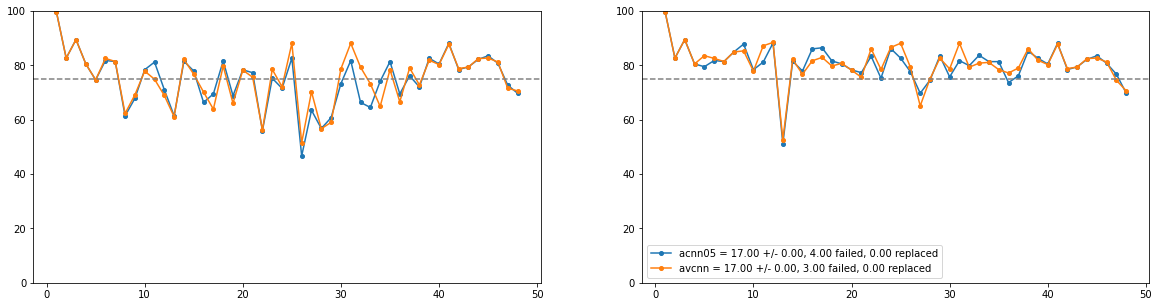

In [22]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
if 'skip' in subs:
    subs = np.delete(subs,subs.index('skip'))
bat = 32
ft = 'tdar'
iter = 6
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
plot_mod = ['lda','alda','cnn','acnn03','avcnn','crcnn']
plot_mod = ['lda','avcnn']
plot_mod = ['acnn05','avcnn']
for plot_i in range(1):
    for sub in range(4,5):    
        it_acc = []
        it_recal = []
        it_fail = []
        it_val = []
        it_prev = []
        it_train = []
        it_times = []
        it_replaced = []
        for it in range(1):#iter):
        
            # load or initialize cnn weights
            if plot_i == 1:
                with open('0323 full run pre and post/' + subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
                    all_acc, all_recal, all_val, all_prev, all_train, all_times, _, mod_tot, c_weights, v_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
            else:
                with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
                    all_acc, all_recal, all_val, all_prev, all_train, all_times, all_dof, _, mod_tot, c_weights, v_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
            
            lda_ind = mod_tot.index('alda') + 1
            all_acc[all_acc==0] = np.nan
            all_val[all_val==0] = np.nan
            all_prev[all_prev==0] = np.nan
            all_train[all_train==0] = np.nan
            all_times[all_times==0] = np.nan

            it_acc.append(all_acc)
            it_recal.append(np.sum(all_recal==1,axis=0))
            it_fail.append(np.sum(all_recal==-1,axis=0))
            it_replaced.append(np.sum(all_recal==-2,axis=0))
            it_val.append(all_val)
            it_prev.append(all_prev)
            it_train.append(all_train)
            it_times.append(all_times)

            it_acc[it][:,:lda_ind] = it_acc[0][:,:lda_ind]
            it_recal[it][:lda_ind] = it_recal[0][:lda_ind]
            it_fail[it][:lda_ind] = it_fail[0][:lda_ind]
            it_replaced[it][:lda_ind] = it_replaced[0][:lda_ind]
            it_val[it][:,:lda_ind] = it_val[0][:,:lda_ind]
            it_prev[it][:,:lda_ind] = it_prev[0][:,:lda_ind]
            it_train[it][:,:lda_ind] = it_train[0][:,:lda_ind]
            it_times[it][:,:lda_ind] = it_times[0][:,:lda_ind]


        it_acc2 = cp.deepcopy(it_acc)
        for i in range(len(it_acc2)):
            x = it_val[i] < 0
            # print(x.type)
            # print(it_acc2[i].shape)
            # print(ave_val.shape)
            it_acc2[i][(it_acc[i]< 0) & (it_val[i] > 0)]= it_val[i][(it_acc[i]< 0)& (it_val[i] > 0)]
            # it_acc2[i][(it_acc[i]< 0)]= it_val[i][(it_acc[i]< 0)]


        ave_acc2 = np.nanmean(np.abs(np.array(it_acc2)),axis=0)
        ave_acc = np.nanmean(np.abs(np.array(it_acc)),axis=0)
        ave_val = np.nanmean(np.abs(np.array(it_val)),axis=0)
        ave_prev = np.nanmean(np.abs(np.array(it_prev)),axis=0)
        ave_train = np.nanmean(np.abs(np.array(it_train)),axis=0)
        ave_times = np.nanmean(np.abs(np.array(it_times)),axis=0)
        ave_recal = np.nanmean(np.array(it_recal),axis=0)
        ave_fail = np.nanmean(np.array(it_fail),axis=0)
        ave_replaced = np.nanmean(np.array(it_replaced),axis=0)

        std_acc2 = np.nanstd(np.abs(np.array(it_acc2)),axis=0)/np.sum(~np.isnan(np.array(it_acc2)),axis=0)
        std_acc = np.nanstd(np.abs(np.array(it_acc)),axis=0)/np.sum(~np.isnan(np.array(it_acc)),axis=0)
        std_val = np.nanstd(np.abs(np.array(it_val)),axis=0)/np.sum(~np.isnan(np.array(it_val)),axis=0)
        std_prev = np.nanstd(np.abs(np.array(it_prev)),axis=0)/np.sum(~np.isnan(np.array(it_prev)),axis=0)
        std_train = np.nanstd(np.abs(np.array(it_train)),axis=0)/np.sum(~np.isnan(np.array(it_train)),axis=0)
        std_times = np.nanstd(np.abs(np.array(it_times)),axis=0)/np.sum(~np.isnan(np.array(it_times)),axis=0)
        std_recal = np.nanstd(np.array(it_recal),axis=0)/np.sum(~np.isnan(np.array(it_recal)),axis=0)
        std_fail = np.nanstd(np.array(it_fail),axis=0)/np.sum(~np.isnan(np.array(it_fail)),axis=0)
        std_replaced = np.nanstd(np.array(it_replaced),axis=0)/np.sum(~np.isnan(np.array(it_replaced)),axis=0)

        fig, ax = plt.subplots(1,2,figsize=(20,5))
        for mod in plot_mod:
            plot_ind = mod_tot.index(mod)
            # ax.plot(ave_acc[2:,plot_ind],'.-',label= mod + ' = '+ str(ave_recal[plot_ind,0]) + ' +/- ' + str(std_recal[plot_ind,0]))
            x = ~np.isnan(ave_val[:,plot_ind]) 
            # ave_acc2 = cp.deepcopy(ave_acc)
            # ave_acc[x,plot_ind] = ave_val[x,plot_ind]

            ax[0].plot(ave_acc[:,plot_ind],'.-',ms=8,label= mod + ' = '+ "{:.2f}".format(ave_recal[plot_ind]) + ' +/- ' + "{:.2f}".format(std_recal[plot_ind]) + ', ' + "{:.2f}".format(ave_fail[plot_ind]) +' failed'+ ', ' + "{:.2f}".format(ave_replaced[plot_ind]) +' replaced')#str(std_recal[plot_ind,0]))
            # ax[0].plot(np.squeeze(np.where(x)),ave_acc[x,plot_ind],'kx',ms=12)
            ax[1].plot(ave_acc2[:,plot_ind],'.-',ms=8,label= mod + ' = '+ "{:.2f}".format(ave_recal[plot_ind]) + ' +/- ' + "{:.2f}".format(std_recal[plot_ind])+ ', ' + "{:.2f}".format(ave_fail[plot_ind]) + ' failed'+ ', ' + "{:.2f}".format(ave_replaced[plot_ind]) +' replaced')#+ str(std_recal[plot_ind,0]))
            # ax.plot(np.squeeze(np.where(x)), ave_val[~np.isnan(ave_val[:,plot_ind]),plot_ind],'.-',ms=8,label= mod + ' = '+ str(ave_recal[plot_ind,0]) + ' +/- ' + str(std_recal[plot_ind,0]))
            # plt.fill_between(np.arange(ave_acc[2:,plot_ind].shape[0]),ave_acc[2:,plot_ind]-std_acc[2:,plot_ind],ave_acc[2:,plot_ind]+std_acc[2:,plot_ind],alpha=.3)
        ax[1].legend()
        for i in range(2):
            ax[i].axhline(75, ls='--', color='grey')
            ax[i].set_ylim([0,100])
        # ax[1].axhline(75, ls='--', color='grey')

In [18]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
if 'skip' in subs:
    subs = np.delete(subs,subs.index('skip'))
bat = 32
load_mod = False
ft = 'tdar'
iter = 10
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_mod = 0

sub_b = []
sub_s = []
sub_sep=[]
for sub in range(2,7):
    print(subs[sub])
    sub_path = path + subs[sub] + '/DATA/MAT/'
    all_files = os.listdir(sub_path)
    if 'skip' in all_files:
        all_files = np.delete(all_files,all_files.index('skip'))

    # load or initialize cnn weights
    acc = np.zeros((len(all_files),2))
    acc_val = np.zeros((len(all_files),2))
    acc_prev = np.zeros((len(all_files),2))
    acc_train = np.zeros((len(all_files),2))
    

    acc_i = 0

    # Loop through files
    for i in range(len(all_files)-1):              
        # load training file
        train_file = all_files[i]
        train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')

        # load training file
        train_data, train_params, th = prd.threshold(train_data, train_params)
        val_data, val_params = train_data, train_params
            
        # get current dofs and create key
        if i == 0:
            train_dof = np.unique(train_params[:,-1])
            key = np.arange(len(train_dof))

            n_dof = len(train_dof)

            h = np.ones((len(all_files),n_dof))
            b = np.ones((len(all_files),n_dof))
            sep = np.zeros((len(all_files),n_dof))
            tot_b = np.ones((len(all_files,)))
            h[:] = np.nan
            b[:] = np.nan

            train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key,False)
            val_data, val_params = lp.check_labels(val_data,val_params,train_dof,key,False)

            _, x_clean_cnn, y_clean, _, x_train_cnn, y_train, x_train_lda, y_train_lda, emg_scale, scaler, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=bat, ft=ft, noise=False, split=False,num_classes=n_dof)

            w, c, mu_class, _, _, N, cov_class = dlda.train_lda(x_train_lda, y_train_lda, key)
            
            cl_s = np.zeros((n_dof,))
            # cl_s[:] = np.nan
            m_cl = np.zeros((n_dof,x_train_lda.shape[1]))
            s_cl = np.zeros((n_dof,x_train_lda.shape[1],x_train_lda.shape[1]))
            for cl in train_dof:
                train_ind = np.squeeze(y_train_lda == key[train_dof==cl])
                temp_x = x_train_lda[train_ind,...]
                m1 = np.nanmean(temp_x,axis=0)
                s1 = np.cov(temp_x.T)
                m_cl[key[train_dof==cl],...] = np.nanmean(temp_x,axis=0)
                s_cl[key[train_dof==cl],...] = np.cov(temp_x.T)
                ct = 0
                for cl_i in train_dof:
                    temp_ind = np.squeeze(y_train_lda == key[train_dof==cl_i])
                    temp_x2 = x_train_lda[temp_ind,...]
                    m2 = np.nanmean(temp_x2,axis=0)
                    s2 = np.cov(temp_x2.T)
                    cl_s[key[train_dof==cl]] += np.nanmean(prd.mahal(m1,s1,m2,s2))
                    ct+=1
                cl_s[key[train_dof==cl]] /= ct

        #del x_train_lda, y_train_lda, x_train_cnn, y_train, x_clean_cnn, y_clean
        
        # load data
        test_file = all_files[i+1]
        test_data, test_params = prd.load_caps_train(sub_path + test_file + '/traindata.mat')
        
        # check class labels
        test_data, test_params, _ = prd.threshold(test_data, test_params, th)
        test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key,True)

        # test 
        y_test, _, x_test_cnn, x_test_lda, y_test_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft, split=False)
        
        # test 
        acc[i+1,:] = lp.test_models(None, None,  x_test_lda, y_test_lda, lda=[w,c])

        for cl in train_dof:
            test_ind = np.squeeze(y_test_lda == key[train_dof==cl])
            if i == 0:
                train_ind = np.squeeze(y_train_lda == key[train_dof==cl])
                m1 = np.nanmean(x_train_lda[train_ind,:],axis=0)
                s1 = np.cov(x_train_lda[train_ind,:].T)
            if np.sum(test_ind) > 50:
                # print(np.sum(test_ind))
                m2 = np.nanmean(x_test_lda[test_ind,:],axis=0)
                s2 = np.cov(x_test_lda[test_ind,:].T)
                h[i+1,key[train_dof==cl]] = prd.hellinger(m1,s1,m2,s2)
                b[i+1,key[train_dof==cl]] = np.nanmean(prd.mahal(m1,s1,m2,s2))
                ct = 0
                for cl_i in train_dof:
                    cl_sep = np.nanmean(prd.mahal(np.squeeze(m_cl[key[train_dof==cl_i],...]),np.squeeze(s_cl[key[train_dof==cl_i],...]),m2,s2))
                    if np.isnan(cl_sep):
                        print('oops')
                    else:
                        ct += 1
                        sep[i+1,key[train_dof==cl]] += cl_sep
                sep[i+1,key[train_dof==cl]] /= ct
                # b[i+1,key[train_dof==cl]] = prd.bhatta(m1,s1,m2,s2)
        # print(h[i+1,:])
        # m1 = np.nanmean(x_train_lda,axis=0)
        # s1 = np.cov(x_train_lda.T)
        # m2 = np.nanmean(x_test_lda,axis=0)
        # s2 = np.cov(x_test_lda.T)
        # b[i+1,0] = np.min(h[i+1,:])

        print("{:.2f}".format(acc[i+1,0]))
        del y_test, x_test_cnn#, x_test_lda, y_test_lda, test_data, test_params

    print(np.median(acc,axis=0))
    with open(subs[sub] + '_hell.p','wb') as f:
        pickle.dump([acc,h,b,cl_s,sep],f)
    sub_b.append(b)
    sub_s.append(cl_s)
    sub_sep.append(sep)
    
    gc.collect(generation=2)

TR58


c:\Users\yteh\Documents\work\git\projects\adaptive\python\adapt\utils\data_utils.py:638: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt((m1-m2).T*(cov_inv)*(m1-m2))


init test dof: [ 1  6 16 17 19 48 53]
test_dof: [ 1  6 16 17 19 48 53], key: [0. 1. 2. 3. 4. 5. 6.]


KeyboardInterrupt: 

In [ ]:
cl = 4
h[h==0] = np.nan



for sub in range(7):
    with open(subs[sub] + '_hell.p','rb') as f:
        acc,h,b,cl_s,sep = pickle.load(f)
    min_h = np.nanmax(h[1:,:],axis=1)
    norm_m = b/np.nanmean(cl_s)
    acc_p = acc[1:,0]
    fig,ax = plt.subplots()
    fig1,ax1 = plt.subplots(1,2,figsize=(15,3))
    # ax.plot(-np.nanmean(b[1:,:],axis=1),acc_p, 'x')
    ax.plot(np.nanmax(b[1:,:],axis=1),acc_p, 'x')
    ax1[0].plot(np.nanmax(b[1:,:],axis=1), 'x')
    ax1[1].plot(acc_p, 'x')
    ax1[1].set_ylim([0,100])
    # ax1[0].set_ylim([0,20])
    # ax.set_xlim([0,4])

In [ ]:
test.shape

In [ ]:
temp = []
for sub in range(7):
    with open(subs[sub] + '_lda_accs.p','rb') as f:
        acc, _ = pickle.load(f)
    temp.append(acc[1,0])

## Test generation

In [ ]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
if 'skip' in subs:
    subs = np.delete(subs,subs.index('skip'))
bat = 128
load_mod = False
mod_tot = ['blda','lda','crlda','alda','bcnn','cnn', 'crcnn','acnn03','acnn30','acewc00','acewc30', 'adcnn30', 'vcnn', 'bvcnn', 'avcnn03', 'avcnn15', 'acnnl03','crvcnn','acewclm','xtra','xtra1','xtra2']
ft = 'feat'
iter = 1

for sub in range(4,5):
    print(subs[sub])
    sub_path = path + subs[sub] + '/DATA/MAT/'
    all_files = os.listdir(sub_path)
    if 'skip' in all_files:
        all_files = np.delete(all_files,all_files.index('skip'))

    # first iteration, includes LDA; others exclude LDA
    mod_all = ['vcnn']

    # load or initialize cnn weights
    if load_mod:
        with open(subs[sub] + '_' + str(0) + '_r_accs.p','rb') as f:
            all_acc, all_recal, all_val, all_prev, all_train, all_times, _, _, c_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
        all_times = np.zeros((len(all_files),len(mod_tot)))
    else:
        c_weights = None
        v_weights = None
        v_wc = None
        cl_wc = None
        all_recal = np.empty((len(mod_tot),1))
        all_recal[:] = np.nan
        all_acc = np.zeros((len(all_files),len(mod_tot)))
        all_val = np.zeros((len(all_files),len(mod_tot)))
        all_prev = np.zeros((len(all_files),len(mod_tot)))
        all_train = np.zeros((len(all_files),len(mod_tot)))
        all_times = np.zeros((len(all_files),len(mod_tot)))

    mod_i = 0
    for mod in mod_all:
        acc = np.zeros((len(all_files),5))
        acc_val = np.zeros((len(all_files),5))
        acc_prev = np.zeros((len(all_files),5))
        acc_train = np.zeros((len(all_files),5))

        if 'cnn' in mod:
            acc_i = 2
        elif 'cewc' in mod:
            acc_i = 4
        elif 'lda' in mod:
            acc_i = 0

        cnn = None
        ewc = None

        ep = 50
        recal = 0
        skip = False

        # Loop through files
        for i in range(1,2):#len(all_files)-1):
            # load training file
            train_file = all_files[i]
            train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')

            train_data, train_params, th = prd.threshold(train_data, train_params)
            val_data = train_data
            val_params = train_params

            train_dof = np.unique(train_params[:,-1])
            key = np.empty(train_dof.shape)
            for key_i in range(len(train_dof)):
                key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])
            n_dof = int(np.max(key))
            
            train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key)
            val_data, val_params = lp.check_labels(val_data,val_params,train_dof,key)

            _, x_clean_cnn, y_clean, _, x_train_cnn, y_train, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False,num_classes=n_dof)

            _, _, _, _, x_val_cnn, y_val, x_val_lda, y_val_lda, _, _, _, _, _ = prd.prep_train_caps(val_data, val_params, emg_scale=emg_scale,scaler=scaler, prop_b=False, batch_size=bat, ft=ft, num_classes=n_dof, noise=False, split=False)

            del train_data, train_params, val_data, val_params

            cnn, all_times[i,mod_tot.index(mod)] = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['vcnn'], n_dof=n_dof, ep=30, dec=True, print_b=True)
            cnn, all_times[i,mod_tot.index(mod)] = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=[cnn], n_dof=n_dof, ep=30, dec=False,print_b=True)

In [ ]:
x_out = cp.deepcopy(x_clean_cnn)
for cl in range(y_clean.shape[1]):
    x_out[y_clean[:,cl]==1,...] = np.random.normal(np.mean(x_clean_cnn[y_clean[:,cl]==1,...],axis=0), np.std(x_clean_cnn[y_clean[:,cl]==1,...],axis=0),x_clean_cnn[y_clean[:,cl]==1,...].shape)


In [ ]:
x_out = cp.deepcopy(x_train_cnn)
for cl in range(y_train.shape[1]):
    x_out[y_train[:,cl]==1,...] = np.random.normal(np.mean(x_train_cnn[y_train[:,cl]==1,...],axis=0), np.std(x_train_cnn[y_train[:,cl]==1,...],axis=0),x_train_cnn[y_train[:,cl]==1,...].shape)


In [ ]:
samp1 = np.ones((1*y_clean.shape[0],8))
x_out,_,_ = cnn.dec(samp1,np.tile(np.argmax(y_clean,axis=1),[1]).astype('float32'),samp=True)
# _,x_out,_,_ = cnn(x_clean_cnn,np.tile(np.argmax(y_clean,axis=1),[1]).astype('float32'),dec=True)
x_out = x_out.numpy()
# for i in range(y_clean.shape[1]):
#     adjust1 = np.std(x_clean_cnn[np.argmax(y_clean,axis=1)==i,...],axis=0)
#     rescale = np.mean(adjust1)/np.mean(np.std(x_out[np.argmax(y_clean,axis=1)==i,...],axis=0))
#     gmean = np.mean(x_out[np.argmax(y_clean,axis=1)==i,...],axis=0)
#     x_out[np.argmax(y_clean,axis=1)==i,...] = (x_out[np.argmax(y_clean,axis=1)==i,...] - gmean)*rescale + gmean
# x_out = np.maximum(np.minimum(x_out,1),0)
for cl in range(y_clean.shape[1]):
    ind = np.tile(np.argmax(y_clean,axis=1)==cl,[1])
    ind2 = np.argmax(y_clean,axis=1)==cl
    x_temp = x_out[ind,...].reshape((np.sum(ind),-1))
    x_true = x_clean_cnn[ind2,...].reshape((np.sum(ind2),-1))
    # for i in range()
    plt.figure()
    # for i in range(x_true.shape[0]):
    #     plt.plot(x_true[i,...],'k-')
        
    for i in range(x_temp.shape[0]):
        plt.plot(x_temp[i,...],'b-')

In [ ]:
x_lda = x_clean_cnn.reshape(x_clean_cnn.shape[0],-1)
y_lda = np.argmax(y_clean,axis=1)[...,np.newaxis]
y_train_lda = np.argmax(y_clean,axis=1)[...,np.newaxis]
w,c, _, _, _, _, _ = dlda.train_lda(x_lda,y_lda)
y_out = dlda.predict(x_lda, w, c)
print(dlda.eval_lda(w, c, x_lda, y_lda))
x_out_lda = x_out.reshape(x_out.shape[0],-1)
print(dlda.eval_lda(w,c, x_out_lda,np.tile(y_train_lda,[1,1])))
w,c, _, _, _, _, _ = dlda.train_lda(x_out_lda,np.tile(y_train_lda,[1,1]))
print(dlda.eval_lda(w, c, x_out_lda,y_train_lda))
print(dlda.eval_lda(w, c, x_lda, np.argmax(y_clean,axis=1)[...,np.newaxis]))

In [ ]:
cnn1, _ = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['vcnn'], n_dof=n_dof, ep=15, dec=False,print_b=True)
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
test_mod = dl.get_test(cnn1,test_accuracy)
print(lp.test_models(x_out, y_clean, None, None, cnn=cnn1, test_mod=test_mod, test_accuracy=test_accuracy))

cnn2, _ = lp.train_models(traincnn=x_out,y_train=y_clean, mod=['vcnn'], n_dof=n_dof, ep=15, dec=False,print_b=True)
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
test_mod = dl.get_test(cnn2,test_accuracy)
print(lp.test_models(x_clean_cnn, y_clean, None, None, cnn=cnn2, test_mod=test_mod, test_accuracy=test_accuracy))

In [ ]:
cv_iter = 1
fig,ax = plt.subplots(1,5,figsize=(30,4))
for sub in range(2,3):#,5):
    with open(subs[sub] + '_0_r_accs.p','rb') as f:
        acc_all, recal_all, cur_all, prev_all, val_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

    # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
    colors =  cm.get_cmap('tab20c')
    c = np.empty((20,4))
    for i in range(20):
        c[i,:] = colors(i*1/20)


    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
    nn_c[0,-1] = 1
    all_m = ['ko-','o-','o-','s-','s-','v-','v-']
    pt_m = ['ko-','o-','o-','o-','s','s','s','s','D']
    nn_c = np.vstack((np.array([0,0,0,1]), c[0,:],c[1,:],c[2,:],c[3,:],c[4,:],c[5,:],c[6,:],c[0,:],c[8,:],c[0,:]))
    # nn_c[0,-1] = 1

    labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
    labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
    # labels = mod_tot

    ax_ind = sub
    it = 0
    for v in [1,2]: 
        i = mod_tot.index(mod_all[v])
        acc_temp = acc_all[1:-1,i]
        if not np.isnan(acc_temp).all():
            x = np.arange(len(acc_temp))
            recal_i = (acc_temp < 0)
            ax[ax_ind].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
            ax[ax_ind].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v],color=nn_c[it,:])
            ax[ax_ind].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
            it+=1

    for i in range(5):
        ax[i].axhline(70, ls='--', color='grey')
        
        ax[i].set_ylim([0,100])
        ax[i].set_title('TR' + str(i+1))
    ax[0].legend()
    ax[2].set_xlabel('Calibration Set')
    ax[0].set_ylabel('Accuracy (%)')
    plt.rc('font', size=15) 

In [ ]:
cv_iter = 1
for sub in range(2,3):#,5):
    fig,ax = plt.subplots(1,4,figsize=(20,4))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, val_all,mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [1,0,0,1,2,2,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[it]+': ' + str(int(recal_all[i,0])),color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
                it+=1

    for i in range(4):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
from matplotlib.ticker import MaxNLocator
cv_iter = 1
for sub in range(0,5):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','o','*','o','s','D','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        labels = ['r-lda','lda','cnn','r-cnn','f-cnn-5','f-cnn-3','f-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [0,0,1,1,1,1,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in [0, 3, 5, 4, 6, 7]: #range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v]+': ' + str(int(recal_all[i,0])),color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[v,:])
                ax[ax_ind[it]].xaxis.set_major_locator(MaxNLocator(integer=True))
                it+=1

    for i in range(2):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
        

    ax[0].set_ylabel('Accuracy (%)')